In [1]:
import networkx as nx
import numpy as np
import torch
from model import CaT
import inference
import pandas as pd
import matplotlib.pyplot as plt
from datasets import get_full_ordering, reorder_dag

!pip install scikit-learn
from sklearn.linear_model import LinearRegression


shuffling = 0
seed = 1
standardize = 0
sample_size = 50000
batch_size = 100
max_iters = 40000
eval_interval = 100
eval_iters = 100
validation_fraction = 0.3
np.random.seed(seed=seed)
torch.manual_seed(seed)
device = 'cuda'
dropout_rate = 0.0
learning_rate = 5e-3
ff_n_embed = 6
num_heads = 1
n_layers = 1
head_size = 6

def generate_data(N, d=1):
    DAGnx = nx.DiGraph()

    
    Uc = np.random.randn(N,d)
    C =  Uc

        
    Ux = np.random.randn(N,d)
    X =  1 * C + Ux
    
    Uy = np.random.randn(N,d)
    Y = 0.8 * X  + 1.5 * C + Uy

    Y0 = 0.8 * 0 + 1.5 * C + Uy
    Y1 = 0.8 * 1  + 1.5 * C +  Uy

    all_data_dict = {'X': X,  'C': C, 'Y': Y}

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'X': 'cont',  'C': 'cont', 'Y': 'cont'}

    DAGnx.add_edges_from([('X', 'Y'), ('C', 'X'), ('C', 'Y')])
    DAGnx = reorder_dag(dag=DAGnx)  # topologically sorted dag
    var_names = list(DAGnx.nodes())  # topologically ordered list of variables
    all_data = np.stack([all_data_dict[key] for key in var_names], axis=1)
    causal_ordering = get_full_ordering(DAGnx)
    ordered_var_types = dict(sorted(var_types.items(), key=lambda item: causal_ordering[item[0]]))

    return all_data, DAGnx, var_names, causal_ordering, ordered_var_types, Y0, Y1




## Confounding Example

In [2]:
d=1
_, _, _, _, _, Y0, Y1 = generate_data(N=1000000, d=d)
ATE = (Y1 - Y0).mean(0)  # multi-dim ATE based off a large sample
all_data, DAGnx, var_names, causal_ordering, var_types, Y0, Y1 = generate_data(N=sample_size, d=d)
print(var_names, ATE)
print(all_data.shape)

['C', 'X', 'Y'] [0.8]
(50000, 3, 1)


In [3]:
X = all_data[:, :2, 0] 
y = all_data[:, 2:3, 0]
reg = LinearRegression().fit(X, y)

reg.coef_

array([[1.49645586, 0.80199006]])

In [70]:
def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

for i in range(10):
    all_data, DAGnx, var_names, causal_ordering, var_types, Y0, Y1 = generate_data(N=sample_size, d=d)
    
    indices = np.arange(0, len(all_data))
    np.random.shuffle(indices)
    
    val_inds = indices[:int(validation_fraction*len(indices))]
    train_inds = indices[int(validation_fraction*len(indices)):]
    train_data = all_data[train_inds]
    val_data = all_data[val_inds]
    train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()
    
    input_dim = all_data.shape[2]
    
    model = CaT(input_dim=input_dim,
                    dropout_rate=dropout_rate,
                    head_size=head_size,
                    num_heads=num_heads,
                    ff_n_embed=ff_n_embed,
                    dag=DAGnx,
                    causal_ordering=causal_ordering,
                    n_layers=n_layers,
                    device=device,
                    var_types=var_types,
                    ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    all_var_losses = {}
    for iter_ in range(0, max_iters):
        # train and update the model
        model.train()
    
        xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
        xb_mod = torch.clone(xb.detach())
        X, loss, loss_dict = model(X=xb, targets=xb_mod, shuffling=shuffling)
    
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    
    
        if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
            for key in loss_dict.keys():
                if key not in all_var_losses.keys():
                    all_var_losses[key] = []
                all_var_losses[key].append(loss_dict[key])
    
            model.eval()
            eval_loss = {}
            for split in ['train', 'val']:
                losses = torch.zeros(eval_iters)
                for k in range(eval_iters):
    
                    xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                                   batch_size=batch_size)
                    xb_mod = torch.clone(xb.detach())
                    X, loss, loss_dict = model(X=xb, targets=xb_mod, shuffling=False)
                    losses[k] = loss.item()
                eval_loss[split] = losses.mean()
            model.train()

    model.eval()
    inf = inference.CausalInference(model=model, device=device)
    
    int_nodes_vals0 = {'X':np.array([0.0,])}
    int_nodes_vals1 = {'X':np.array([1.0,])}
    effect_var = 'Y'
    effect_index = var_names.index(effect_var)
    
    preds0 = inf.forward(all_data, int_nodes_vals0)
    preds1 = inf.forward(all_data, int_nodes_vals1)
    ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
    eATE = np.abs(ATE_pred - ATE)
    print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)



ATE: [0.8] est ATE: [1.28523455] error: [0.48523455]
ATE: [0.8] est ATE: [1.1920612] error: [0.3920612]
ATE: [0.8] est ATE: [1.16595427] error: [0.36595427]
ATE: [0.8] est ATE: [1.06473034] error: [0.26473034]
ATE: [0.8] est ATE: [1.40649713] error: [0.60649713]
ATE: [0.8] est ATE: [1.23959588] error: [0.43959588]
ATE: [0.8] est ATE: [1.03233396] error: [0.23233396]
ATE: [0.8] est ATE: [1.0258575] error: [0.2258575]
ATE: [0.8] est ATE: [1.3953697] error: [0.5953697]
ATE: [0.8] est ATE: [0.98706922] error: [0.18706922]


ATE: [0.8 0.8 0.8] est ATE: [1.35116442 1.30697672 1.31493569] error: [0.55116442 0.50697672 0.51493569]


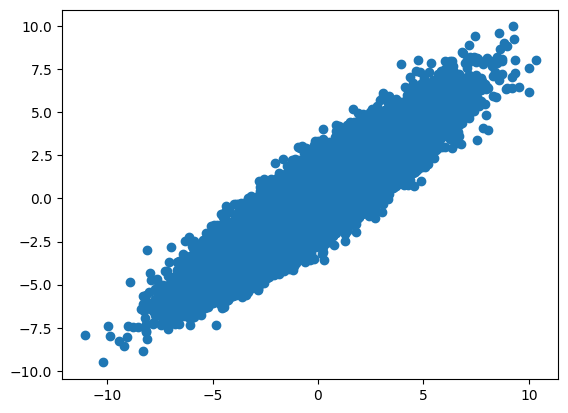

In [21]:
model.eval()
inf = inference.CausalInference(model=model, device=device)

int_nodes_vals0 = {'X':np.array([0.0,])}
int_nodes_vals1 = {'X':np.array([1.0,])}
effect_var = 'Y'
effect_index = var_names.index(effect_var)

preds0 = inf.forward(all_data, int_nodes_vals0)
preds1 = inf.forward(all_data, int_nodes_vals1)
ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
eATE = np.abs(ATE_pred - ATE)
print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)

preds = model(train_data.to(device))

plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())

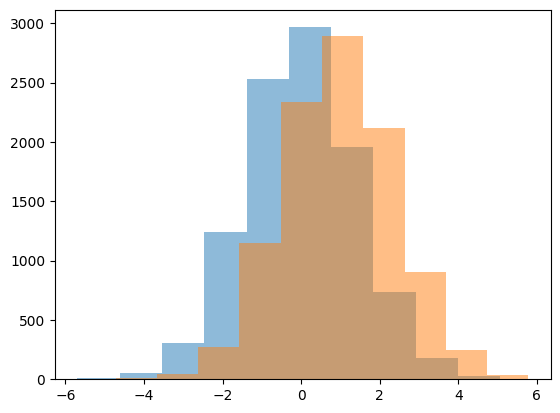

In [6]:

plt.hist(preds0[:,3, 0], alpha=0.5)
plt.hist(preds1[:,3, 0], alpha=0.5)
plt.show()